<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [1]:
#pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.0
IPython 5.1.0

numpy 1.11.3
scipy 0.18.1
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.8.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [3]:
!vw --version

8.3.2


##  1.1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [29]:
class SGDRegressor(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    w_ = None
    
    def __init__(self, eta = 0.001, n_iter = 10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = list()
        self.weights_ = list()
        
    def fit(self, X, y):
        rows = len(X)
        X_bias = X
        X_bias = np.insert(X_bias,0,1, axis=1)
        columns = len(X_bias.T)
        w = [0 for i in range(columns)]
        weights = list()
        
        for i in range(self.n_iter):
            for j in range(rows):
                h = w[0] + w[1]*X_bias[j,1]
                w[0] = w[0] + self.eta*(y[j]-h)
                w[1] = w[1] + self.eta*(y[j]-h)*X_bias[j,1]
                
                weights.append(list(w))
                y_pred = np.cumsum(w*X_bias, axis=1)[:,1]
                self.mse_.append(mean_squared_error(y,y_pred))
        self.weights_ = weights        
        min_index = self.mse_.index(min(self.mse_))    
        self.w_ = weights[min_index]
        return self
    
    def predict(self, X):
        X_bias = X
        X_bias = np.insert(X_bias,0,1, axis=1)
        return np.cumsum(self.w_*X_bias, axis=1)[:,1]

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

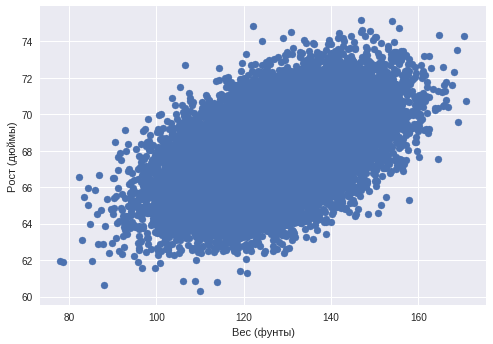

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [5]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [30]:
''' ВАШ КОД ЗДЕСЬ '''
est = SGDRegressor()
fitted = est.fit(X_train_scaled, y_train)

In [31]:
fitted.w_
fitted.mse_

[4616.8529206557669,
 4608.3375526145255,
 4598.768933110513,
 4589.6238426350819,
 4580.3012281872961,
 4571.6400797392653,
 4561.8011722001438,
 4552.4239520745223,
 4543.2913135484087,
 4534.2473812372291,
 4525.1795855814435,
 4515.5790154605638,
 4507.0600778240632,
 4497.6642671194095,
 4488.3535206876622,
 4479.4885414455184,
 4470.5238585418865,
 4461.9406932694974,
 4453.1646041783797,
 4444.2000360303718,
 4435.2433177892208,
 4425.8916005069495,
 4417.5909835496268,
 4408.7999401251727,
 4400.4683298597165,
 4391.8690197349097,
 4383.1110261165768,
 4373.8379599078453,
 4364.3451454380966,
 4356.270791417086,
 4347.72366968802,
 4338.7476408927514,
 4330.4559750881263,
 4321.5505552580362,
 4313.9630315355907,
 4304.9159894515333,
 4296.3027236845182,
 4288.0131901494397,
 4279.4093925868101,
 4270.2878062971049,
 4261.454002522366,
 4252.8484669877053,
 4244.4782610131024,
 4236.6110989543531,
 4228.6629700394169,
 4220.0899502044558,
 4211.2367378547488,
 4203.361033694715

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

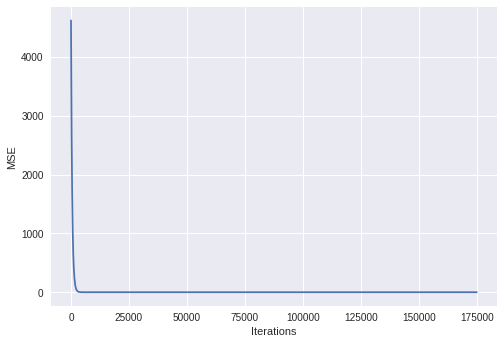

In [39]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(fitted.mse_)
plt.ylabel('MSE')
plt.xlabel('Iterations');

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [33]:
''' ВАШ КОД ЗДЕСЬ '''
print('min MSE value:',  min(fitted.mse_))
print('best vector', fitted.w_)

min MSE value: 2.71513524066
best vector [67.989849695913833, 0.9444760534047697]


In [34]:
print(y[:10])
print(fitted.predict(X_train_scaled[:10]))

[ 65.78331  71.51521  69.39874  68.2166   67.78781  68.69784  69.80204
  70.01472  67.90265  66.78236]
[ 67.42038186  66.68620063  68.34718007  67.22735761  68.6351933
  66.19274177  68.97057884  68.24917738  68.41824669  66.49137629]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

[0.069034319999999996, -0.041623951193777264]
[0.13309347263496285, -0.13004403808665371]
[0.20322098965308616, -0.10351219315385665]
[0.27158748145363976, -0.15870566156619834]
[0.33971318471396683, -0.11215658623404987]
[0.40584437485807351, -0.23798813678009154]
[0.47741268363762202, -0.16367272568256014]
[0.54658743107641439, -0.14467920305378759]
[0.61384144747450453, -0.11417401647742449]
[0.68280208143773335, -0.2235845995707883]


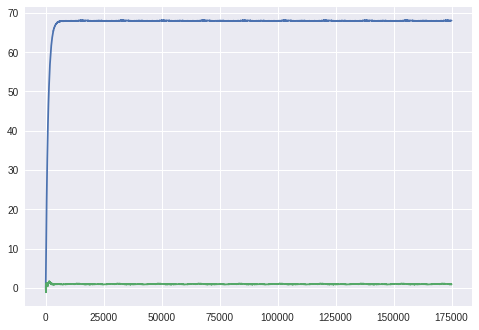

In [40]:
''' ВАШ КОД ЗДЕСЬ '''
for i in fitted.weights_[:10]:
    print(i)

w0 = [i[0] for i in fitted.weights_]
w1 = [i[1] for i in fitted.weights_]
plt.plot(w0)
plt.plot(w1)
#plt.plot(fitted.weights_[:,0])
#plt.plot(fitted.weights_[:,1])
#fitted.weights_

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [41]:
''' ВАШ КОД ЗДЕСЬ '''
pred = fitted.predict(X_valid_scaled)
mean_squared_error(y_valid, pred)

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [42]:
''' ВАШ КОД ЗДЕСЬ '''
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
fitLr = lr.fit(X_train_scaled, y_train)
pr = fitLr.predict(X_valid_scaled)
mean_squared_error(y_valid, pr)
#ответ - 5

2.6708307676676348

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5 - этот

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [2]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [3]:
def kroneker(j):
    return j != 0

In [4]:
def log_func(X,y,w, C):
    return C*log(1+exp(-1*y.dot(w.T.dot(X))))

In [5]:
class SGDClassifier(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    w_ = None
    
    def __init__(self, C, eta = 0.001, n_iter = 10):
        self.eta = eta
        self.n_iter = n_iter
        self.C = C
        self.loss_ = list()
        self.weights_ = list()
        
    def fit(self, X, y):
        rows = len(X)
        X_bias = np.insert(X,0,1, axis=1)
        columns = len(X_bias.T)
        w = [0 for i in range(columns)]
        
        for i in range(self.n_iter):
            for j in range(rows):
                w_array = np.array(w)
                sigm = sigma((-1)*y[j]*w_array.T.dot(X_bias[j]))
                #print(sigm)
                #print(X_bias[j])
                w_kroneker = [val if idx != 0 else 0 for idx,val in enumerate(w)]
                w = w + self.eta*(self.C*y[j]*sigm*X_bias[j]-w_kroneker)
                
                y_pred = []
                for m in range(rows):
                    pred = 0
                    for n in range(columns):
                        pred += X_bias[m,n]*w[n]
                    y_pred.append(sigma(pred))    
                
                #y_pred = [1 if val > 0.5 else -1 for val in y_pred]
                
                #y_pred = [sum(np.log(sigma(X_bias[m]*w))) for m in range(rows)]
                #xwp = X_bias.dot(w)
                #z = np.array(y).T.dot(xwp)
                #y_pred = self.C * sigm_sum
                #print(y_pred)
                self.loss_.append(log_loss(y,y_pred))
                self.weights_.append(list(w))
        min_index = self.loss_.index(min(self.loss_))    
        self.w_ = self.weights_[min_index]
        return self
    
    def predict_proba(self, X):
        X_bias = np.insert(X,0,1, axis=1)
        rows = len(X)
        columns = len(X_bias.T)
        #y_pred = np.ndarray(shape=(2,rows))
        y_pred = [[],[]]
        for m in range(rows):
            pred = 0
            for n in range(columns):
                pred += X_bias[m,n]*self.w_[n]
            sigm = sigma(pred)
            y_pred[0].append(1-sigm)
            y_pred[1].append(sigm)
        return y_pred
    
    def predict(self, X):
        preds = self.predict_proba(X)
        return [1 if val > 0.5 else -1 for val in preds[1]]
                  

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [6]:
from sklearn.datasets import load_breast_cancer

In [7]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [10]:
''' ВАШ КОД ЗДЕСЬ '''
est = SGDClassifier(C=1,eta=0.001,n_iter=3)
est.fit(X_train_scaled, y_train)

SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

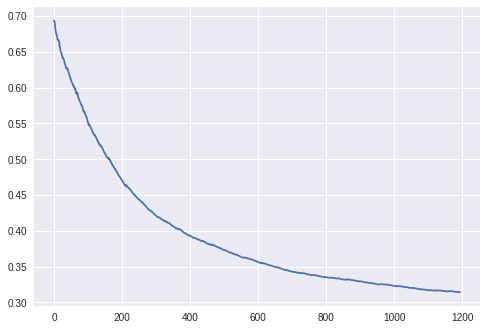

In [11]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(est.loss_)

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [12]:
''' ВАШ КОД ЗДЕСЬ '''
est_1000 = SGDClassifier(C=1000,n_iter=10)
est_1000.fit(X_train_scaled, y_train)

SGDClassifier(C=1000, eta=0.001, n_iter=10)

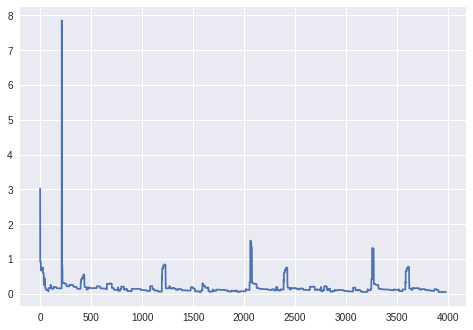

In [13]:
plt.plot(est_1000.loss_)

In [14]:
min(est_1000.loss_)

0.048786010364350527

In [19]:
cancer.feature_names.shape
weights = list(est_1000.w_[1:])
print(est_1000.w_[0])
#print(list(zip(cancer.feature_names, weights)))
for i in range(len(weights)):
    print(cancer.feature_names[i],":", weights[i])
    
#min_abs = max([abs(i) for i in weights])
#print(min_abs)
#print(weights.index(min_abs))
#print(cancer.feature_names[14])

print(min(weights))
idx = weights.index(min(weights))
print(idx)
print(cancer.feature_names[idx])
#concavity
print(cancer.feature_names[np.argmax(abs(weights))])

3.09122261479
mean radius : -1.65755319737
mean texture : -3.41387355348
mean perimeter : -1.40982226129
mean area : -1.66493134529
mean smoothness : -0.177202570641
mean compactness : 1.97826990908
mean concavity : -3.56690964338
mean concave points : -3.54327573464
mean symmetry : 0.418501303706
mean fractal dimension : 2.8603495442
radius error : -4.53181879742
texture error : 2.79177430294
perimeter error : -2.57528860706
area error : -3.15458401451
smoothness error : 0.603031960059
compactness error : 4.53505883747
concavity error : 0.293037875593
concave points error : 0.0796667664818
symmetry error : -0.520205554539
fractal dimension error : 4.66066769902
worst radius : -2.92418605761
worst texture : -4.05156370779
worst perimeter : -1.63955219482
worst area : -2.51138523072
worst smoothness : -1.85871540147
worst compactness : -0.72097361475
worst concavity : -5.1073427726
worst concave points : -1.97909981511
worst symmetry : -1.5991014713
worst fractal dimension : -2.29297816

TypeError: bad operand type for abs(): 'list'

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [17]:
''' ВАШ КОД ЗДЕСЬ '''
pred = est_1000.predict(X_valid_scaled)
proba = est_1000.predict_proba(X_valid_scaled)
print("loss: ", log_loss(y_valid, proba[1]))
print("roc auc: ", roc_auc_score(y_valid, proba[1]))

loss:  0.434411079396
roc auc:  0.976304023845


Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [18]:
''' ВАШ КОД ЗДЕСЬ '''
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=17)
lr.fit(X_train_scaled, y_train)

pred = lr.predict(X_valid_scaled)
proba = lr.predict_proba(X_valid_scaled)
print(len(proba[:,1]))
print(type(proba))

print("loss: ", log_loss(y_valid, proba[:,1]))
print("roc auc: ", roc_auc_score(y_valid, proba[:,1]))

171
<class 'numpy.ndarray'>
loss:  0.105692134779
roc auc:  0.989269746647


## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [239]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [240]:
# поменяйте путь к файлу
reviews_train = load_files("/home/anna/python/mlcourse_open/data/aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target

In [241]:
reviews_test = load_files("/home/anna/python/mlcourse_open/data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [242]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 47.9 s, sys: 548 ms, total: 48.4 s
Wall time: 48.5 s


In [243]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

In [244]:
y_train.shape

(25000,)

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [251]:
%%time
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=17)
lr.fit(X_train, y_train)
pred = lr.predict_proba(X_test)
print(roc_auc_score(y_test, pred[:,1]))

0.9582471424
CPU times: user 2min 8s, sys: 1.92 s, total: 2min 10s
Wall time: 1min 6s


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска - да
 - Реализован линейный SVM - да
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам - да
 - Можно обучать LASSO - да
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному) - да


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [252]:
%%time
cool_sgd = SGDClassifier(loss='log',random_state=17,n_iter=100)
cool_sgd.fit(X_train, y_train)
pred = cool_sgd.predict_proba(X_test)
print(roc_auc_score(y_test, pred[:,1]))

0.9572894656
CPU times: user 13.7 s, sys: 8 ms, total: 13.7 s
Wall time: 13.4 s


In [ ]:
#3

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5